<a href="https://colab.research.google.com/github/bchou9/eec289Ahw/blob/main/EEC289A_HW2_Opara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib as plt
import scipy.stats as st #for gaussian kernel
import scipy.misc
import os

from random import randint, gauss
from math import floor
from skimage import io, feature, transform
from IPython.display import clear_output

#for gif making
import imageio
from PIL import Image

def textureSynthesis(exampleMapPath, outputSize, searchKernelSize, savePath, attenuation = 80, truncation = 0.8, snapshots = True):

    #PARAMETERS
    PARM_attenuation = attenuation
    PARM_truncation = truncation
    #write
    #text_file = open(savePath + 'params.txt', "w")
    #text_file.write("Attenuation: %d \n Truncation: %f \n KernelSize: %d" % (PARM_attenuation, PARM_truncation, searchKernelSize))
    #text_file.close()

    #check whether searchKernelSize is odd:
    if searchKernelSize % 2 == 0:
        searchKernelSize = searchKernelSize + 1

    #load example map image
    exampleMap = loadExampleMap(exampleMapPath)
    imgRows, imgCols, imgChs = np.shape(exampleMap)

    #initialize the image to be generated = canvas; + take a random 3x3 patch and put it in the center of the canvas
    canvas, filledMap = initCanvas(exampleMap, outputSize)

    #precalculate the array of examples patches from the example map
    examplePatches = prepareExamplePatches(exampleMap, searchKernelSize)

    #find pixels that need resolution (weighted by the amount of resolved neighbours they have)
    resolved_pixels = 3 * 3
    pixels_to_resolve = outputSize[0]*outputSize[1]

    #MAIN LOOP-------------------------------------------------------

    #init a map of best candidates to be resolved (we want to reuse the information)
    bestCandidateMap = np.zeros(np.shape(filledMap))

    while resolved_pixels < pixels_to_resolve:

        #update Candidate Map
        updateCandidateMap(bestCandidateMap, filledMap, 5) # 1.42 ms

        #get best candidate coordinates
        candidate_row, candidate_col = getBestCandidateCoord(bestCandidateMap, outputSize)  #978 us

        #get a candidatePatch to compare to
        candidatePatch = getNeighbourhood(canvas, searchKernelSize, candidate_row, candidate_col) # 6.48 ms

        #get a maskMap
        candidatePatchMask = getNeighbourhood(filledMap, searchKernelSize, candidate_row, candidate_col)  #2.24 ms
        #weight it by gaussian
        candidatePatchMask *= gkern(np.shape(candidatePatchMask)[0], np.shape(candidatePatchMask)[1])
        #cast to 3d array
        candidatePatchMask = np.repeat(candidatePatchMask[:, :, np.newaxis], 3, axis=2)

        #now we need to compare it with every examplePatch and construct the distance metric
        #copy everything to match the dimensions of the examplesPatches
        examplePatches_num = np.shape(examplePatches)[0]
        candidatePatchMask = np.repeat(candidatePatchMask[np.newaxis, :, :, :, ], examplePatches_num, axis=0)
        candidatePatch = np.repeat(candidatePatch[np.newaxis, :, :, :, ], examplePatches_num, axis=0)

        distances = candidatePatchMask * pow(examplePatches - candidatePatch, 2)
        distances = np.sum(np.sum(np.sum(distances, axis=3), axis=2), axis=1) #sum all pixels of a patch into single number

        #convert distances into probabilities
        probabilities = distances2probability(distances, PARM_truncation, PARM_attenuation)

        #sample the constructed PMF and fetch the appropriate pixel value
        sample = np.random.choice(np.arange(examplePatches_num), 1, p=probabilities)
        chosenPatch = examplePatches[sample]
        halfKernel = floor(searchKernelSize / 2)
        chosenPixel = np.copy(chosenPatch[0, halfKernel, halfKernel])

        #resolvePixel
        canvas[candidate_row, candidate_col, :] = chosenPixel
        filledMap[candidate_row, candidate_col] = 1

        #show live update
        #plt.pyplot.imshow(canvas)
        #clear_output(wait=True)
        #display(plt.pyplot.show())

        resolved_pixels = resolved_pixels+1

        #save image
        if snapshots:
            img = Image.fromarray(np.uint8(canvas*255))
            img = img.resize((300, 300), resample=0, box=None)
            img.save(savePath + 'out' + str(resolved_pixels-9) + '.jpg')

    #save image
    if snapshots==False:
        #show live update
        plt.pyplot.imshow(canvas)
        clear_output(wait=True)
        display(plt.pyplot.show())
        img = Image.fromarray(np.uint8(canvas*255))
        img = img.resize((300, 300), resample=0, box=None)
        img.save(savePath + 'out.jpg')


def distances2probability(distances, PARM_truncation, PARM_attenuation):

    probabilities = 1 - distances / np.max(distances)
    probabilities *= (probabilities > PARM_truncation)
    probabilities = pow(probabilities, PARM_attenuation) #attenuate the values
    #check if we didn't truncate everything!
    if np.sum(probabilities) == 0:
        #then just revert it
        probabilities = 1 - distances / np.max(distances)
        probabilities *= (probabilities > PARM_truncation*np.max(probabilities)) # truncate the values (we want top truncate%)
        probabilities = pow(probabilities, PARM_attenuation)
    probabilities /= np.sum(probabilities) #normalize so they add up to one

    return probabilities

def getBestCandidateCoord(bestCandidateMap, outputSize):

    candidate_row = floor(np.argmax(bestCandidateMap) / outputSize[0])
    candidate_col = np.argmax(bestCandidateMap) - candidate_row * outputSize[1]

    return candidate_row, candidate_col

def loadExampleMap(exampleMapPath):
    exampleMap = io.imread(exampleMapPath) #returns an MxNx3 array
    exampleMap = exampleMap / 255.0 #normalize
    #make sure it is 3channel RGB
    if (np.shape(exampleMap)[-1] > 3):
        exampleMap = exampleMap[:,:,:3] #remove Alpha Channel
    elif (len(np.shape(exampleMap)) == 2):
        exampleMap = np.repeat(exampleMap[np.newaxis, :, :], 3, axis=0) #convert from Grayscale to RGB
    return exampleMap

def getNeighbourhood(mapToGetNeighbourhoodFrom, kernelSize, row, col):

    halfKernel = floor(kernelSize / 2)

    if mapToGetNeighbourhoodFrom.ndim == 3:
        npad = ((halfKernel, halfKernel), (halfKernel, halfKernel), (0, 0))
    elif mapToGetNeighbourhoodFrom.ndim == 2:
        npad = ((halfKernel, halfKernel), (halfKernel, halfKernel))
    else:
        print('ERROR: getNeighbourhood function received a map of invalid dimension!')

    paddedMap = np.lib.pad(mapToGetNeighbourhoodFrom, npad, 'constant', constant_values=0)

    shifted_row = row + halfKernel
    shifted_col = col + halfKernel

    row_start = shifted_row - halfKernel
    row_end = shifted_row + halfKernel + 1
    col_start = shifted_col - halfKernel
    col_end = shifted_col + halfKernel + 1

    return paddedMap[row_start:row_end, col_start:col_end]

def updateCandidateMap(bestCandidateMap, filledMap, kernelSize):
    bestCandidateMap *= 1 - filledMap #remove all resolved from the map
    #check if bestCandidateMap is empty
    if np.argmax(bestCandidateMap) == 0:
        #populate from sratch
        for r in range(np.shape(bestCandidateMap)[0]):
            for c in range(np.shape(bestCandidateMap)[1]):
                bestCandidateMap[r, c] = np.sum(getNeighbourhood(filledMap, kernelSize, r, c))

def initCanvas(exampleMap, size):

    #get exampleMap dimensions
    imgRows, imgCols, imgChs = np.shape(exampleMap)

    #create empty canvas
    canvas = np.zeros((size[0], size[1], imgChs)) #inherit number of channels from example map
    filledMap = np.zeros((size[0], size[1])) #map showing which pixels have been resolved

    #init a random 3x3 block
    margin = 1
    rand_row = randint(margin, imgRows - margin - 1)
    rand_col = randint(margin, imgCols - margin - 1)
    exampleMap_patch = exampleMap[rand_row-margin:rand_row+margin+1, rand_col-margin:rand_col+margin+1] #need +1 because last element not included
     #plt.pyplot.imshow(exampleMap_patch)
     #print(np.shape(exampleMap_patch))

    #put it in the center of our canvas
    center_row = floor(size[0] / 2)
    center_col = floor(size[1] / 2)
    canvas[center_row-margin:center_row+margin+1, center_col-margin:center_col+margin+1] = exampleMap_patch
    filledMap[center_row-margin:center_row+margin+1, center_col-margin:center_col+margin+1] = 1 #mark those pixels as resolved

    return canvas, filledMap

def prepareExamplePatches(exampleMap, searchKernelSize):

    #get exampleMap dimensions
    imgRows, imgCols, imgChs = np.shape(exampleMap)

    #find out possible steps for a search window to slide along the image
    num_horiz_patches = imgRows - (searchKernelSize-1);
    num_vert_patches = imgCols - (searchKernelSize-1);

    #init candidates array
    examplePatches = np.zeros((num_horiz_patches*num_vert_patches, searchKernelSize, searchKernelSize, imgChs))

    #populate the array
    for r in range(num_horiz_patches):
        for c in range(num_vert_patches):
            examplePatches[r*num_vert_patches + c] = exampleMap[r:r+searchKernelSize, c:c+searchKernelSize]

    return examplePatches

def gkern(kern_x, kern_y, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    """altered copy from https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy"""

    # X
    interval = (2*nsig+1.)/(kern_x)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kern_x+1)
    kern1d_x = np.diff(st.norm.cdf(x))
    # Y
    interval = (2*nsig+1.)/(kern_y)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kern_y+1)
    kern1d_y = np.diff(st.norm.cdf(x))

    kernel_raw = np.sqrt(np.outer(kern1d_x, kern1d_y))
    kernel = kernel_raw/kernel_raw.sum()

    return kernel

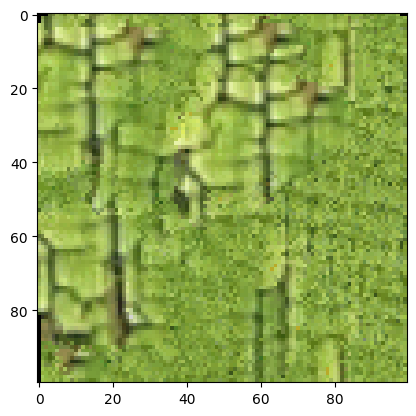

None

In [ ]:
#PUT YOUR PARAMETERS HERE
exampleMapPath = "imagesample.png"
outputSize = [100,100]
outputPath = "out8.png"
searchKernelSize = 21

textureSynthesis(exampleMapPath, outputSize, searchKernelSize, outputPath, attenuation = 80, truncation = 0.8, snapshots = False)